In [31]:
%reload_ext autoreload
%autoreload 2

import os

os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import math
import numpy as np
import pandas as pd
import datetime
from pytz import UTC, timezone
import seaborn as sns
from datetime import datetime, timedelta
import concurrent.futures

from watttime import WattTimeForecast, WattTimeHistorical, RecalculatingWattTimeOptimizer

import data.s3 as s3u
import evaluation.eval_framework as efu
from plotnine import *

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)
hist_data = WattTimeForecast(username, password)

s3 = s3u.s3_utils()
pd.options.mode.chained_assignment = None  # default='warn'
import random


In [34]:
def random_date_with_time(start, end):

    time_between_dates = end - start
    random_number_of_seconds = random.randint(0, int(time_between_dates.total_seconds()))
    random_date = start + timedelta(seconds=random_number_of_seconds)
    
    random_hour = random.randint(0, 23)
    random_minute = random.randint(0, 59)
    
    random_date_with_time = random_date.replace(hour=random_hour, minute=random_minute)
    return random_date_with_time

In [35]:
random_date_with_time(datetime(2023, 1, 1), datetime(2023, 12, 31))

datetime.datetime(2023, 7, 2, 11, 52, 48)

In [71]:
region = "SPP_TX"

full_forecast = s3.load_parquetdataframe(f"complete_2023_forecast_history/{region}.parquet").drop_duplicates()
full_forecast['point_time'] = pd.to_datetime(full_forecast['point_time'], utc=True)

full_history = s3.load_parquetdataframe(f"complete_2023_actual_history/{region}.parquet").drop_duplicates()

In [72]:
increments = [5, 15, 30, 60, 120, 180, 240, 360]
start_time = pd.to_datetime(random_date_with_time(datetime(2023, 1, 1), datetime(2023, 12, 31))).tz_localize('UTC')
end_time = start_time + timedelta(hours = 12)
usage_power_kw = 2
time_needed = 180

In [ ]:
baseline_forecast

In [74]:
%%capture

results = {}
all_relevant_forecasts = full_forecast.set_index("generated_at")[start_time - timedelta(minutes = 5):end_time]
baseline_forecast = all_relevant_forecasts.loc[all_relevant_forecasts.index.min()].reset_index()
schedules = []

ideal = efu.get_schedule_and_cost_api_requerying(region = "SOCO",
                                     usage_power_kw = 2,
                                     time_needed = 180,
                                     start_time = start_time,
                                     end_time = end_time, 
                                     optimization_method="simple",
                                     moer_list = [full_history.set_index("point_time")[start_time:end_time].reset_index()]).reset_index().rename({"pred_moer" : "actual_moer"}, axis = 1)

results["ideal_emissions"] = round(ideal["emissions_co2e_lb"].sum(), 2)
ideal["increment"] = "Ideal"
ideal["pred_moer"] = ideal["actual_moer"]
ideal["actual_emissions"] = ideal["actual_moer"]*ideal["energy_usage_mwh"]
schedules.append(ideal)


baseline = efu.get_schedule_and_cost_api_requerying(region = region,
                                     usage_power_kw = usage_power_kw,
                                     time_needed = time_needed,
                                     start_time = start_time,
                                     end_time = end_time, 
                                     optimization_method="baseline",
                                     moer_list = [baseline_forecast]).reset_index()

baseline = baseline.merge(ideal[["point_time", "actual_moer"]])

baseline["increment"] = "Baseline"
baseline["actual_emissions"] = baseline["actual_moer"]*baseline["energy_usage_mwh"]

schedules.append(baseline)

results["baseline_predicted_emissions"] = round(baseline["emissions_co2e_lb"].sum(), 2)
results["baseline_actual_emissions"] = round((baseline["actual_moer"]*baseline["energy_usage_mwh"]).sum(), 2)

no_requery = efu.get_schedule_and_cost_api_requerying(region = region,
                                     usage_power_kw = usage_power_kw,
                                     time_needed = time_needed,
                                     start_time = start_time,
                                     end_time = end_time, 
                                     optimization_method="simple",
                                     moer_list = [baseline_forecast]).reset_index()

no_requery = no_requery.merge(ideal[["point_time", "actual_moer"]])
no_requery["increment"] = "No requery"
no_requery["actual_emissions"] = no_requery["actual_moer"]*no_requery["energy_usage_mwh"]
schedules.append(no_requery)

results["no_requery_predicted_emissions"] = round(no_requery["emissions_co2e_lb"].sum(), 2)
results["no_requery_actual_emissions"] = round((no_requery["actual_moer"]*no_requery["energy_usage_mwh"]).sum(), 2)



for increment in increments:
    inc_times = pd.date_range(all_relevant_forecasts.index.min(), all_relevant_forecasts.index.max(), freq=timedelta(minutes=increment))
    moer_list = [all_relevant_forecasts.loc[timestamp].reset_index() for timestamp in inc_times]

    print(len(moer_list))

    schedule = efu.get_schedule_and_cost_api_requerying(region = region,
                                     usage_power_kw = 2,
                                     time_needed = 180,
                                     start_time = start_time,
                                     end_time = end_time, 
                                     optimization_method="simple",
                                     moer_list = moer_list).reset_index()
    
    
    schedule = schedule.merge(ideal[["point_time", "actual_moer"]])
    schedule["actual_emissions"] = schedule["actual_moer"]*schedule["energy_usage_mwh"]
    schedule["increment"] = f"Requery {increment} minutes"
    schedules.append(schedule)


    results[f"schedule_predicted_emissions_requery_{increment}"] = round(schedule["emissions_co2e_lb"].sum(), 2)
    results[f"schedule_actual_emissions_requery_{increment}"] = round((schedule["actual_moer"]*schedule["energy_usage_mwh"]).sum(), 2)

In [75]:
for sch in schedules:
    mse = ((sch["pred_moer"] - sch["actual_moer"])**2).sum()
    print(f"MSE: {mse}")

MSE: 0.0
MSE: 1078268.93
MSE: 1078268.93
MSE: 9912.979999999992
MSE: 14279.519999999999
MSE: 25745.91
MSE: 20743.430000000015
MSE: 46274.88999999999
MSE: 410747.54
MSE: 665591.3400000001
MSE: 833004.44


In [76]:
increment_order = [f"Requery {increment} minutes" for increment in increments]
order = ["Ideal", "Baseline", "No requery"] + increment_order[::-1]
full_schedules = pd.concat(schedules)
full_schedules["increment"] = pd.Categorical(full_schedules["increment"], order, ordered = True)

/tmp/ipykernel_257995/226672176.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


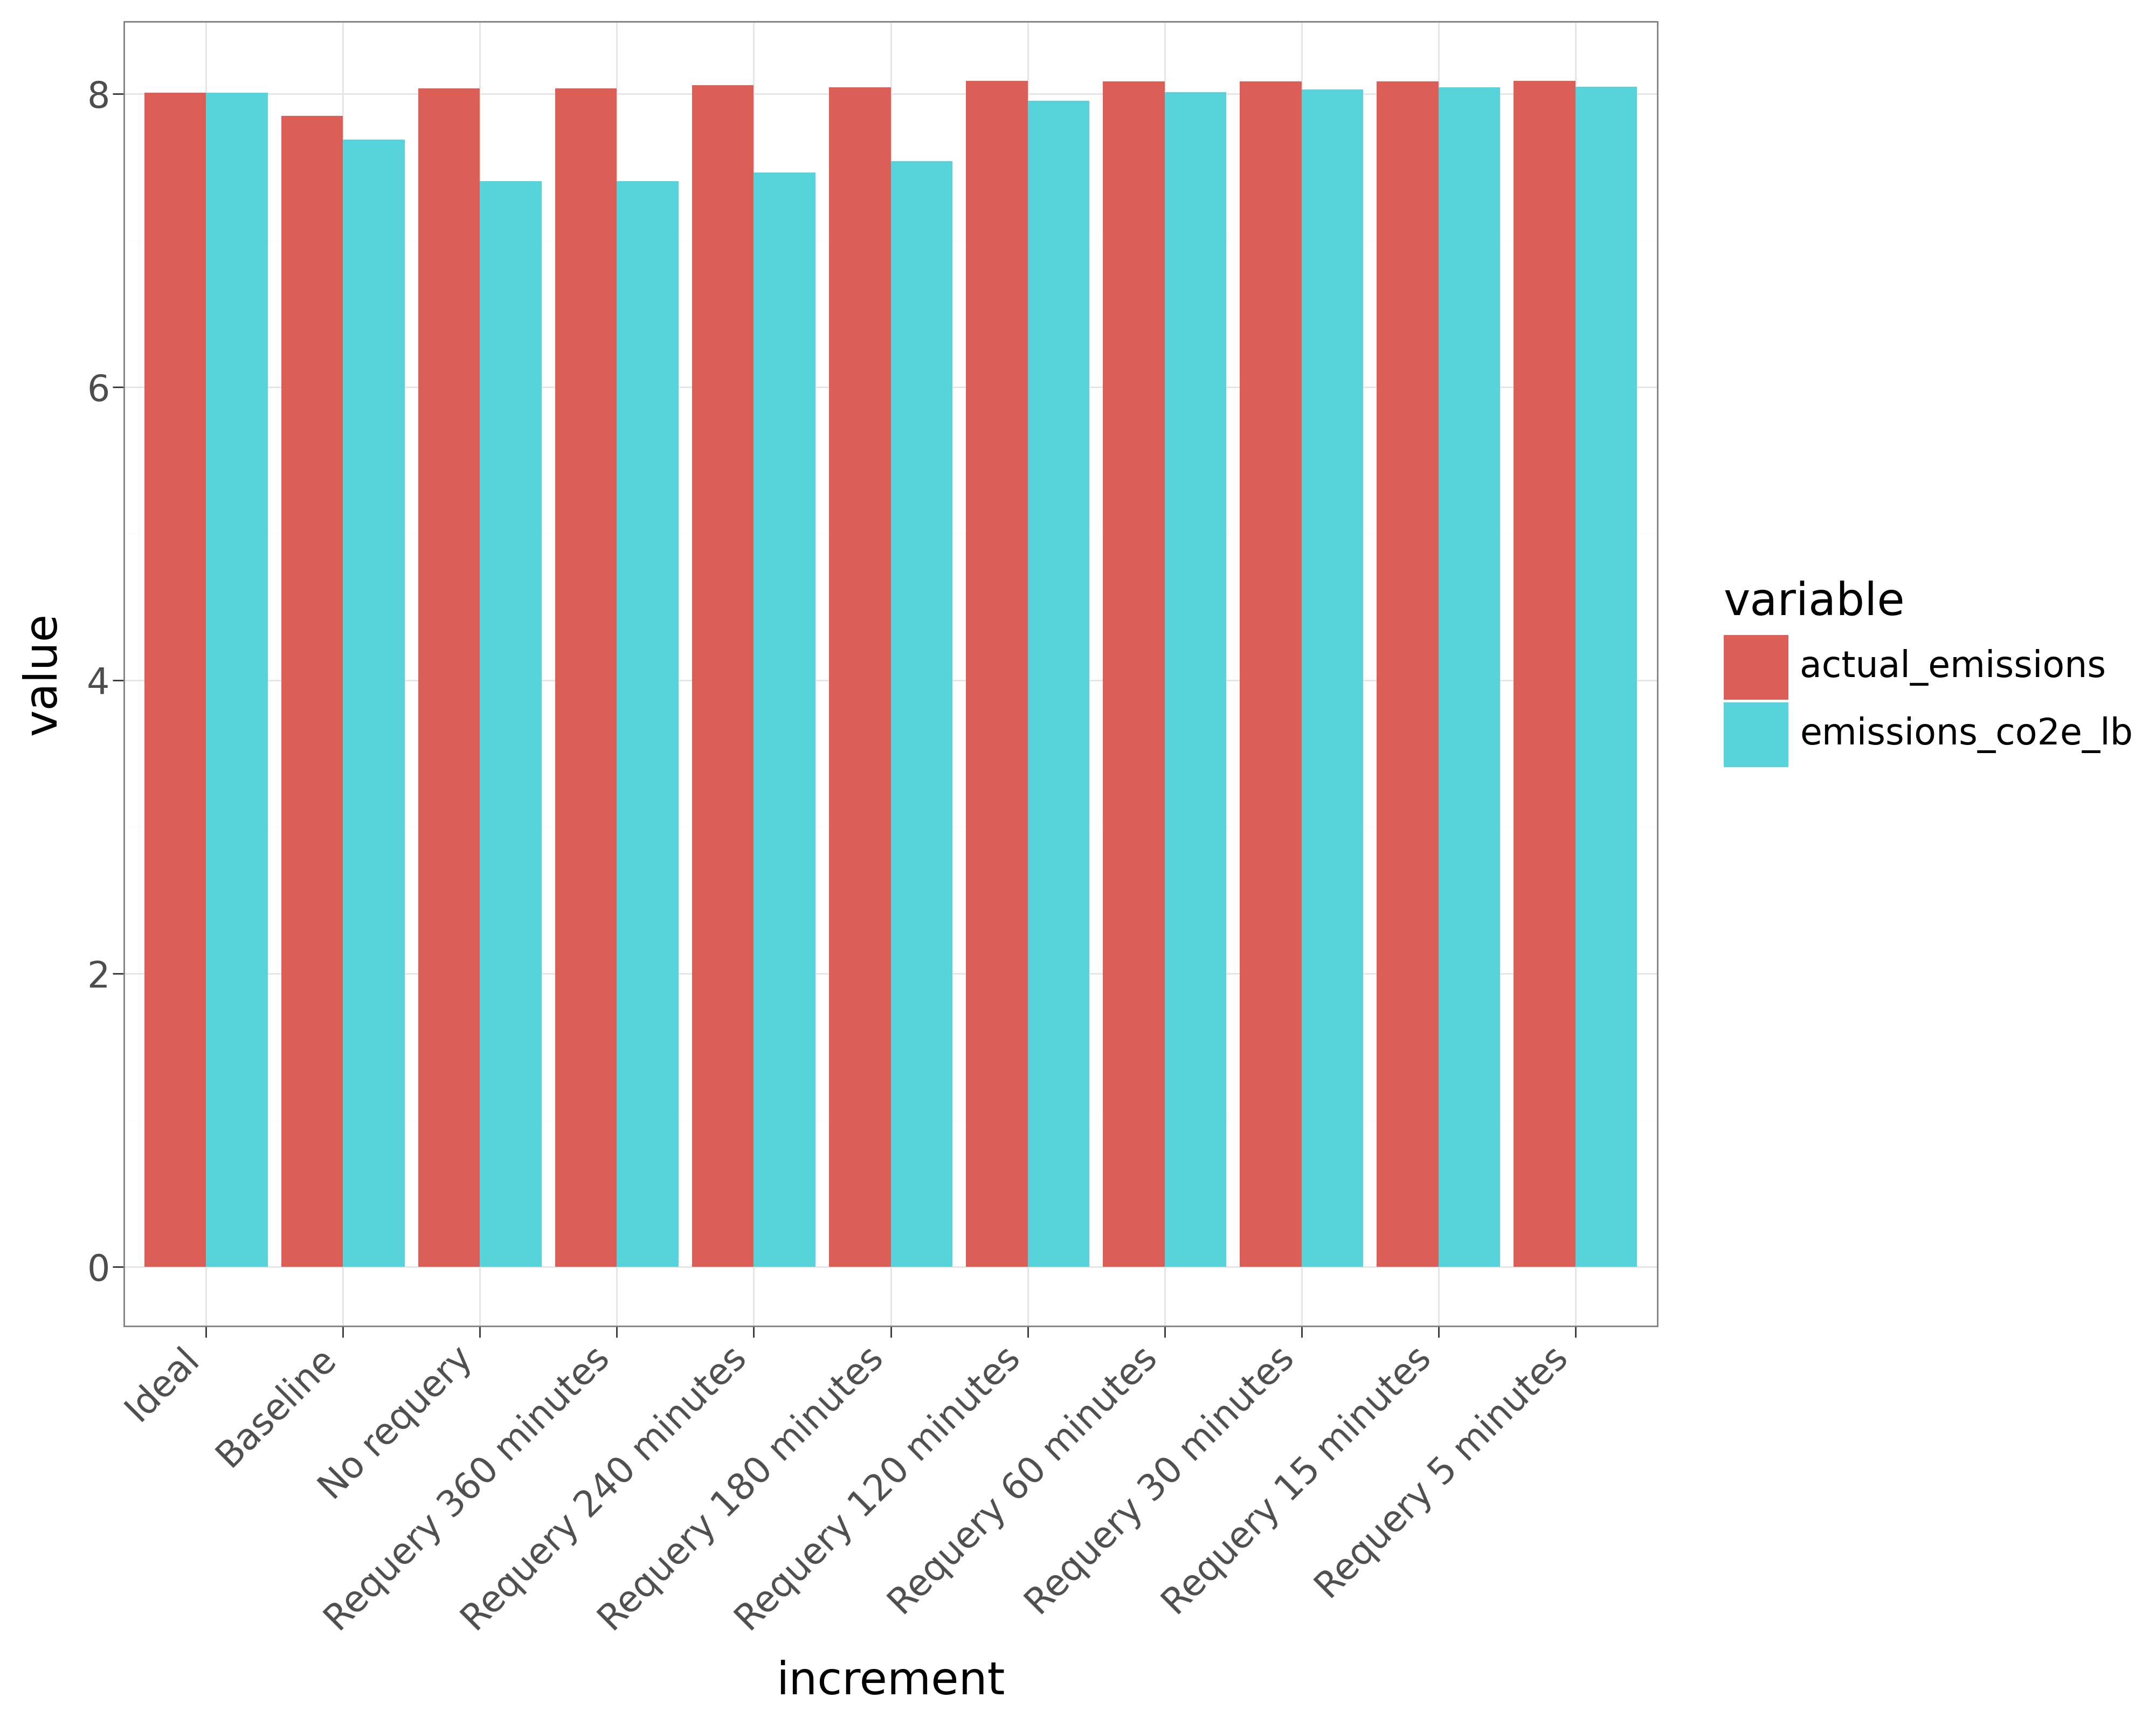

In [81]:
plot_dat = full_schedules.groupby(["increment"])[["actual_emissions", "emissions_co2e_lb"]].sum().reset_index().melt(id_vars="increment")
(ggplot(plot_dat, aes(x = "increment", y = "value", fill = "variable")) + geom_bar(stat = "identity", position = "dodge") + theme_bw(base_size=30) +
     theme(figure_size=(20, 16),
           axis_text_x=element_text(angle=45, hjust=1)) 
    )

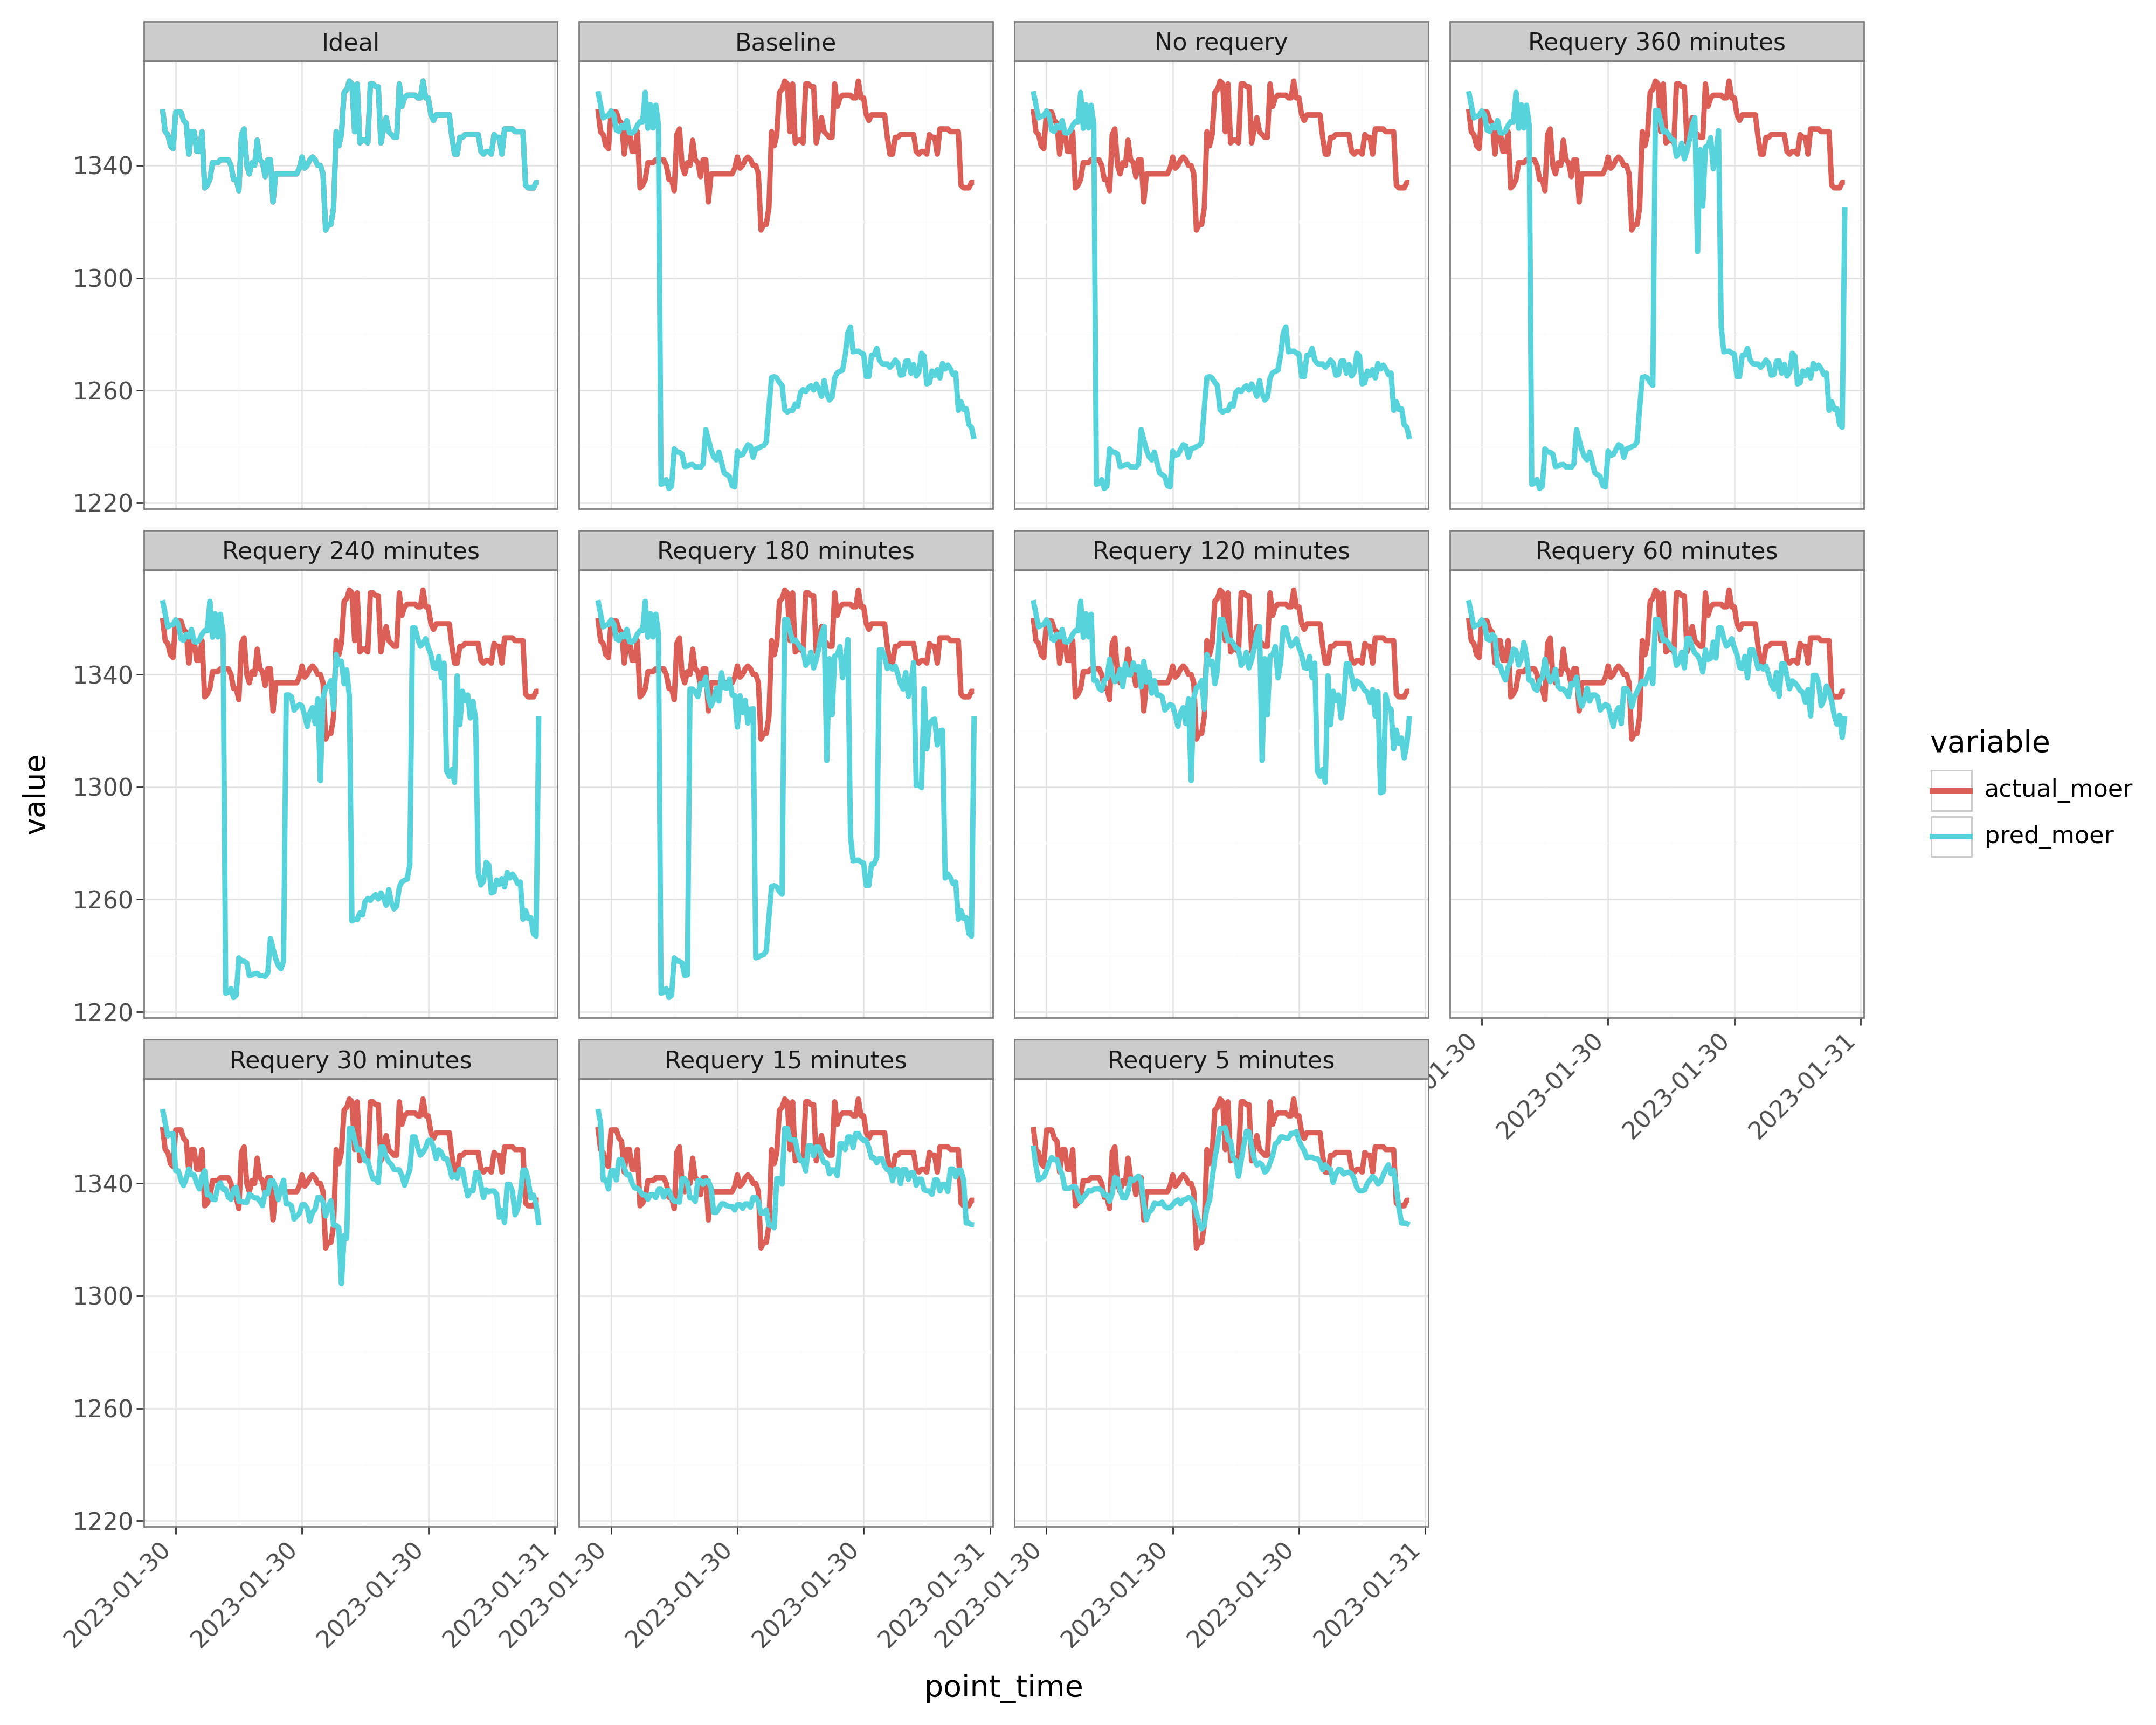

In [78]:
plot_dat = full_schedules.melt(id_vars = ["point_time", "increment"], value_vars=["actual_moer", "pred_moer"])
p = (ggplot(plot_dat, aes(x="point_time", y="value", color = "variable")) +
     geom_line(size=2) +
     facet_wrap("~increment") +
     theme_bw(base_size=20) +
     theme(figure_size=(20, 16),
           axis_text_x=element_text(angle=45, hjust=1))  # Rotate x-axis labels
    )

p

/tmp/ipykernel_257995/4264498665.py:9: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


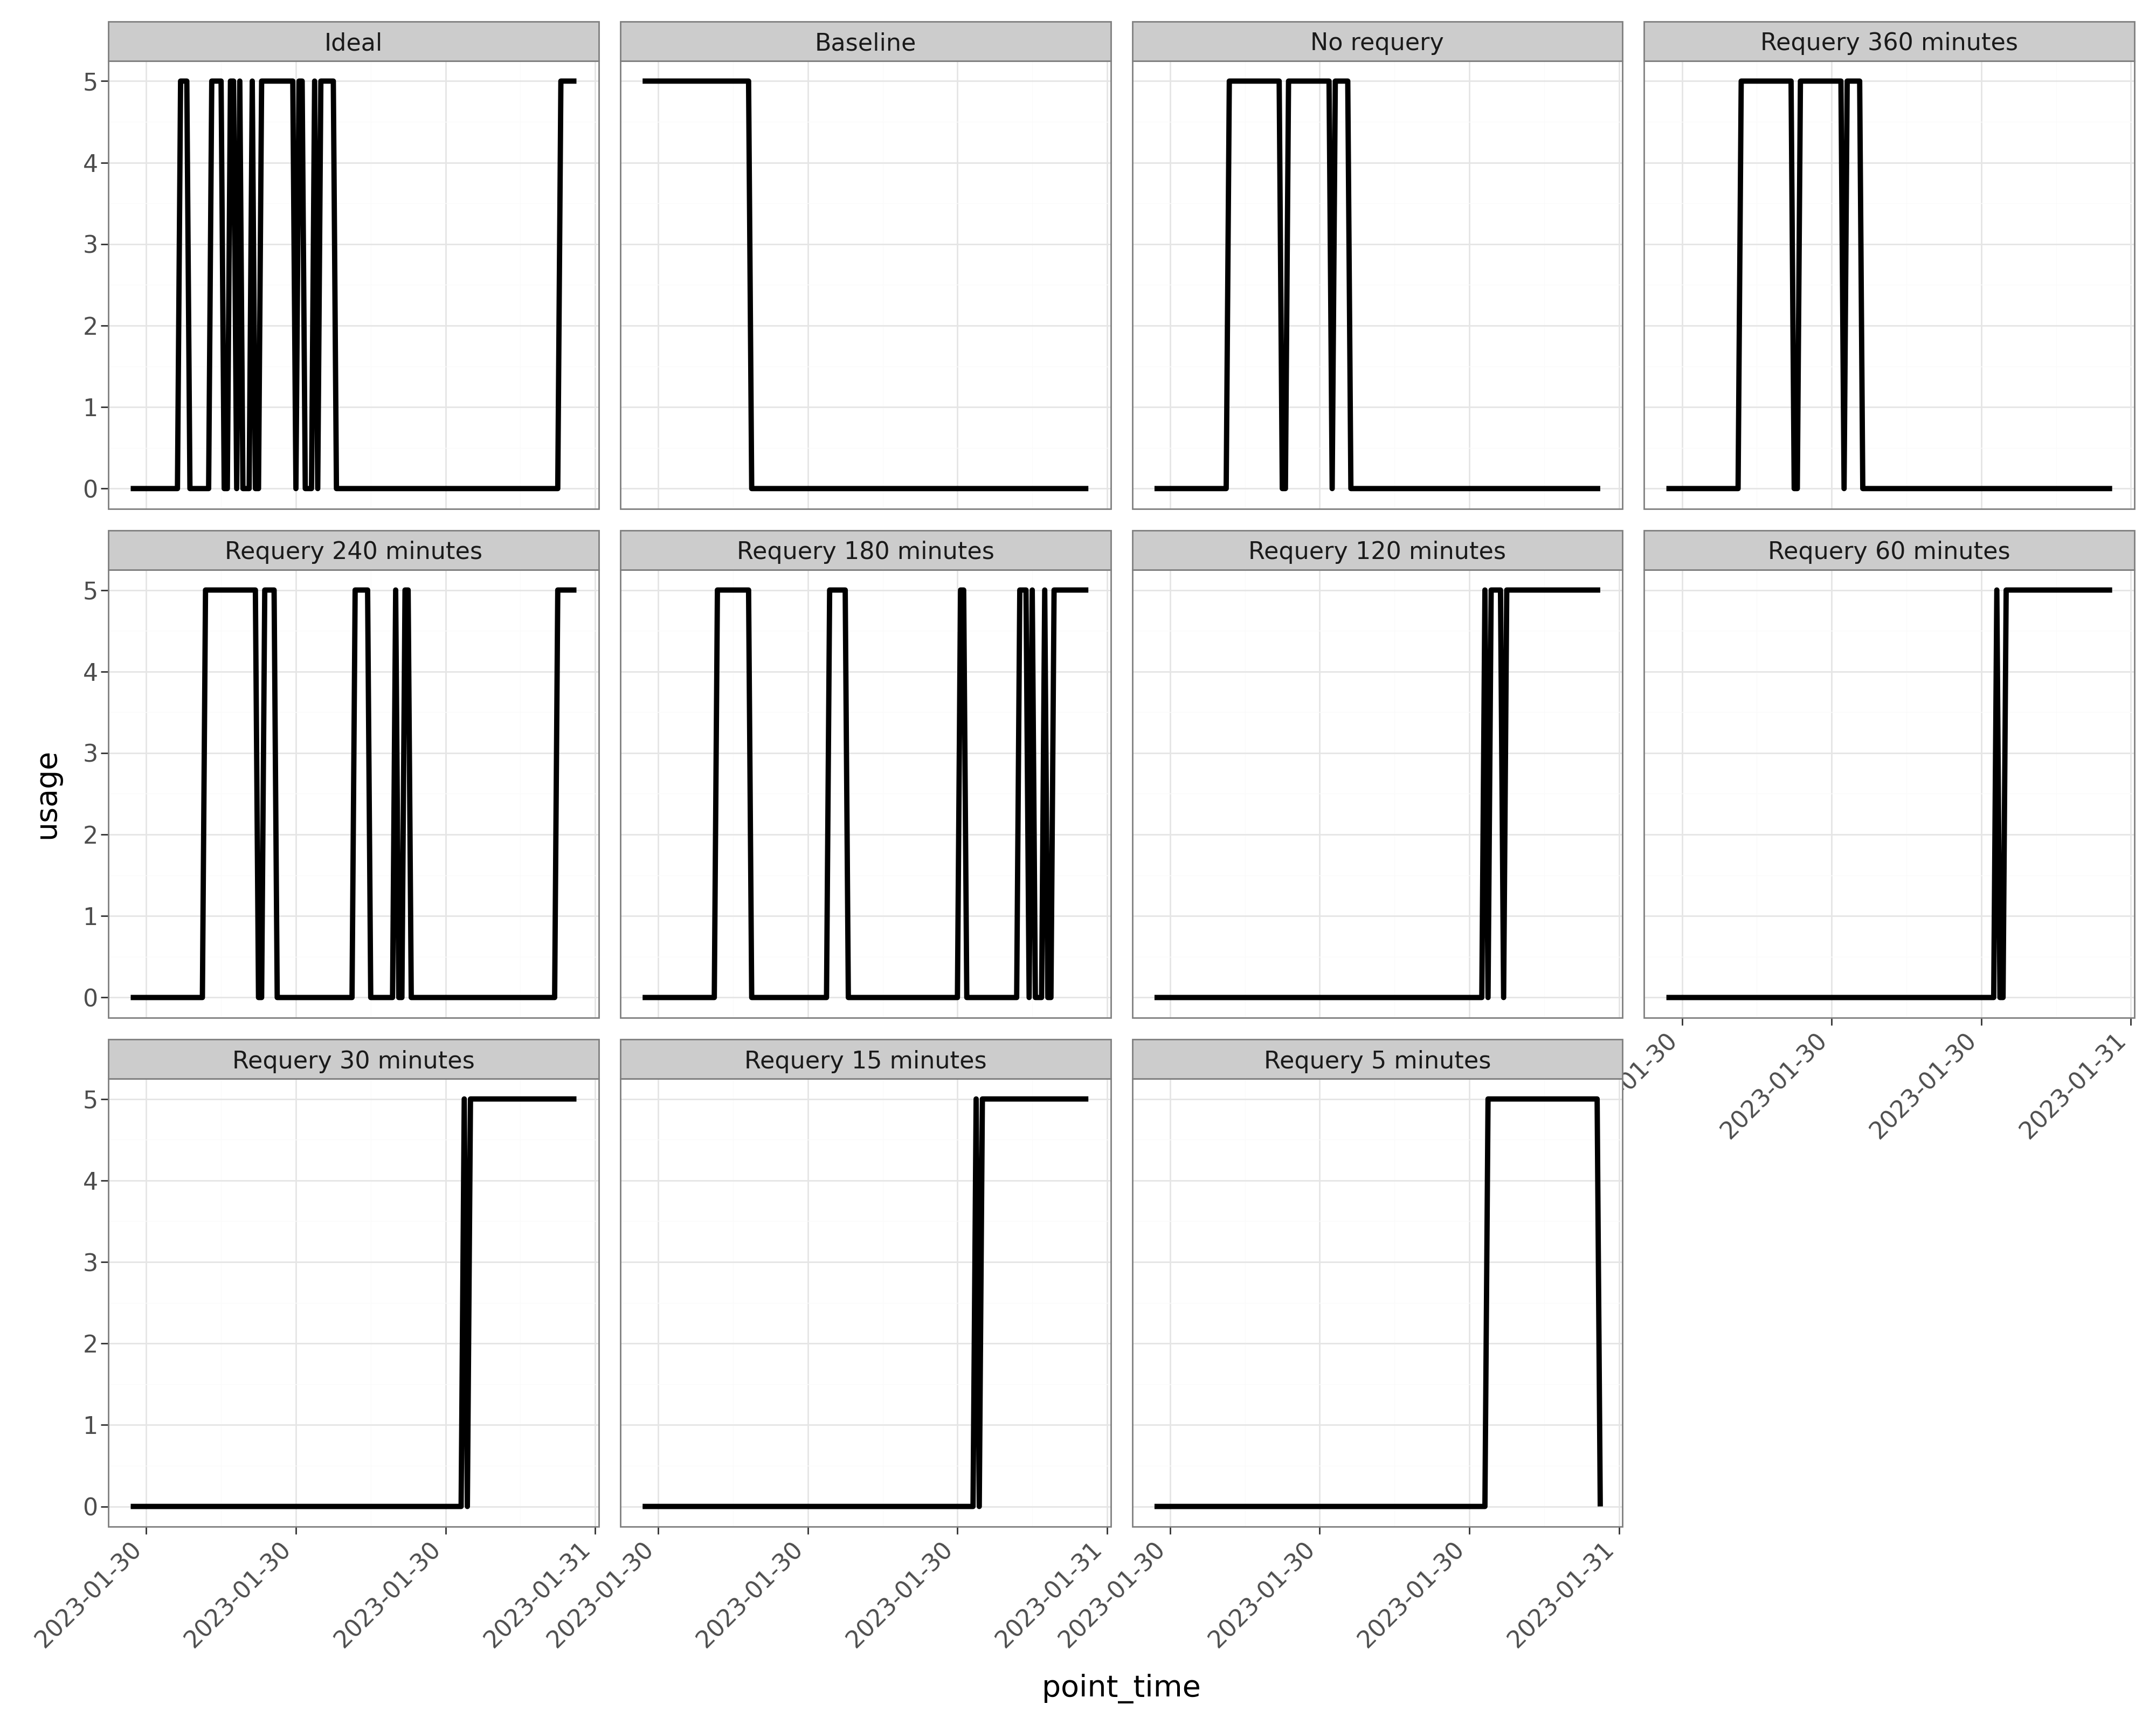

In [79]:
p = (ggplot(full_schedules, aes(x="point_time", y="usage")) +
     geom_line(size=2) +
     facet_wrap("~increment") +
     theme_bw(base_size=20) +
     theme(figure_size=(20, 16),
           axis_text_x=element_text(angle=45, hjust=1))  # Rotate x-axis labels
    )

print(p)

In [83]:
full_schedules.groupby("increment")["usage"].sum()

/tmp/ipykernel_257995/3224851140.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


increment
Ideal                  180.0
Baseline               175.0
No requery             180.0
Requery 360 minutes    180.0
Requery 240 minutes    180.0
Requery 180 minutes    180.0
Requery 120 minutes    180.0
Requery 60 minutes     180.0
Requery 30 minutes     180.0
Requery 15 minutes     180.0
Requery 5 minutes      180.0
Name: usage, dtype: float64

/tmp/ipykernel_257995/1348524240.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


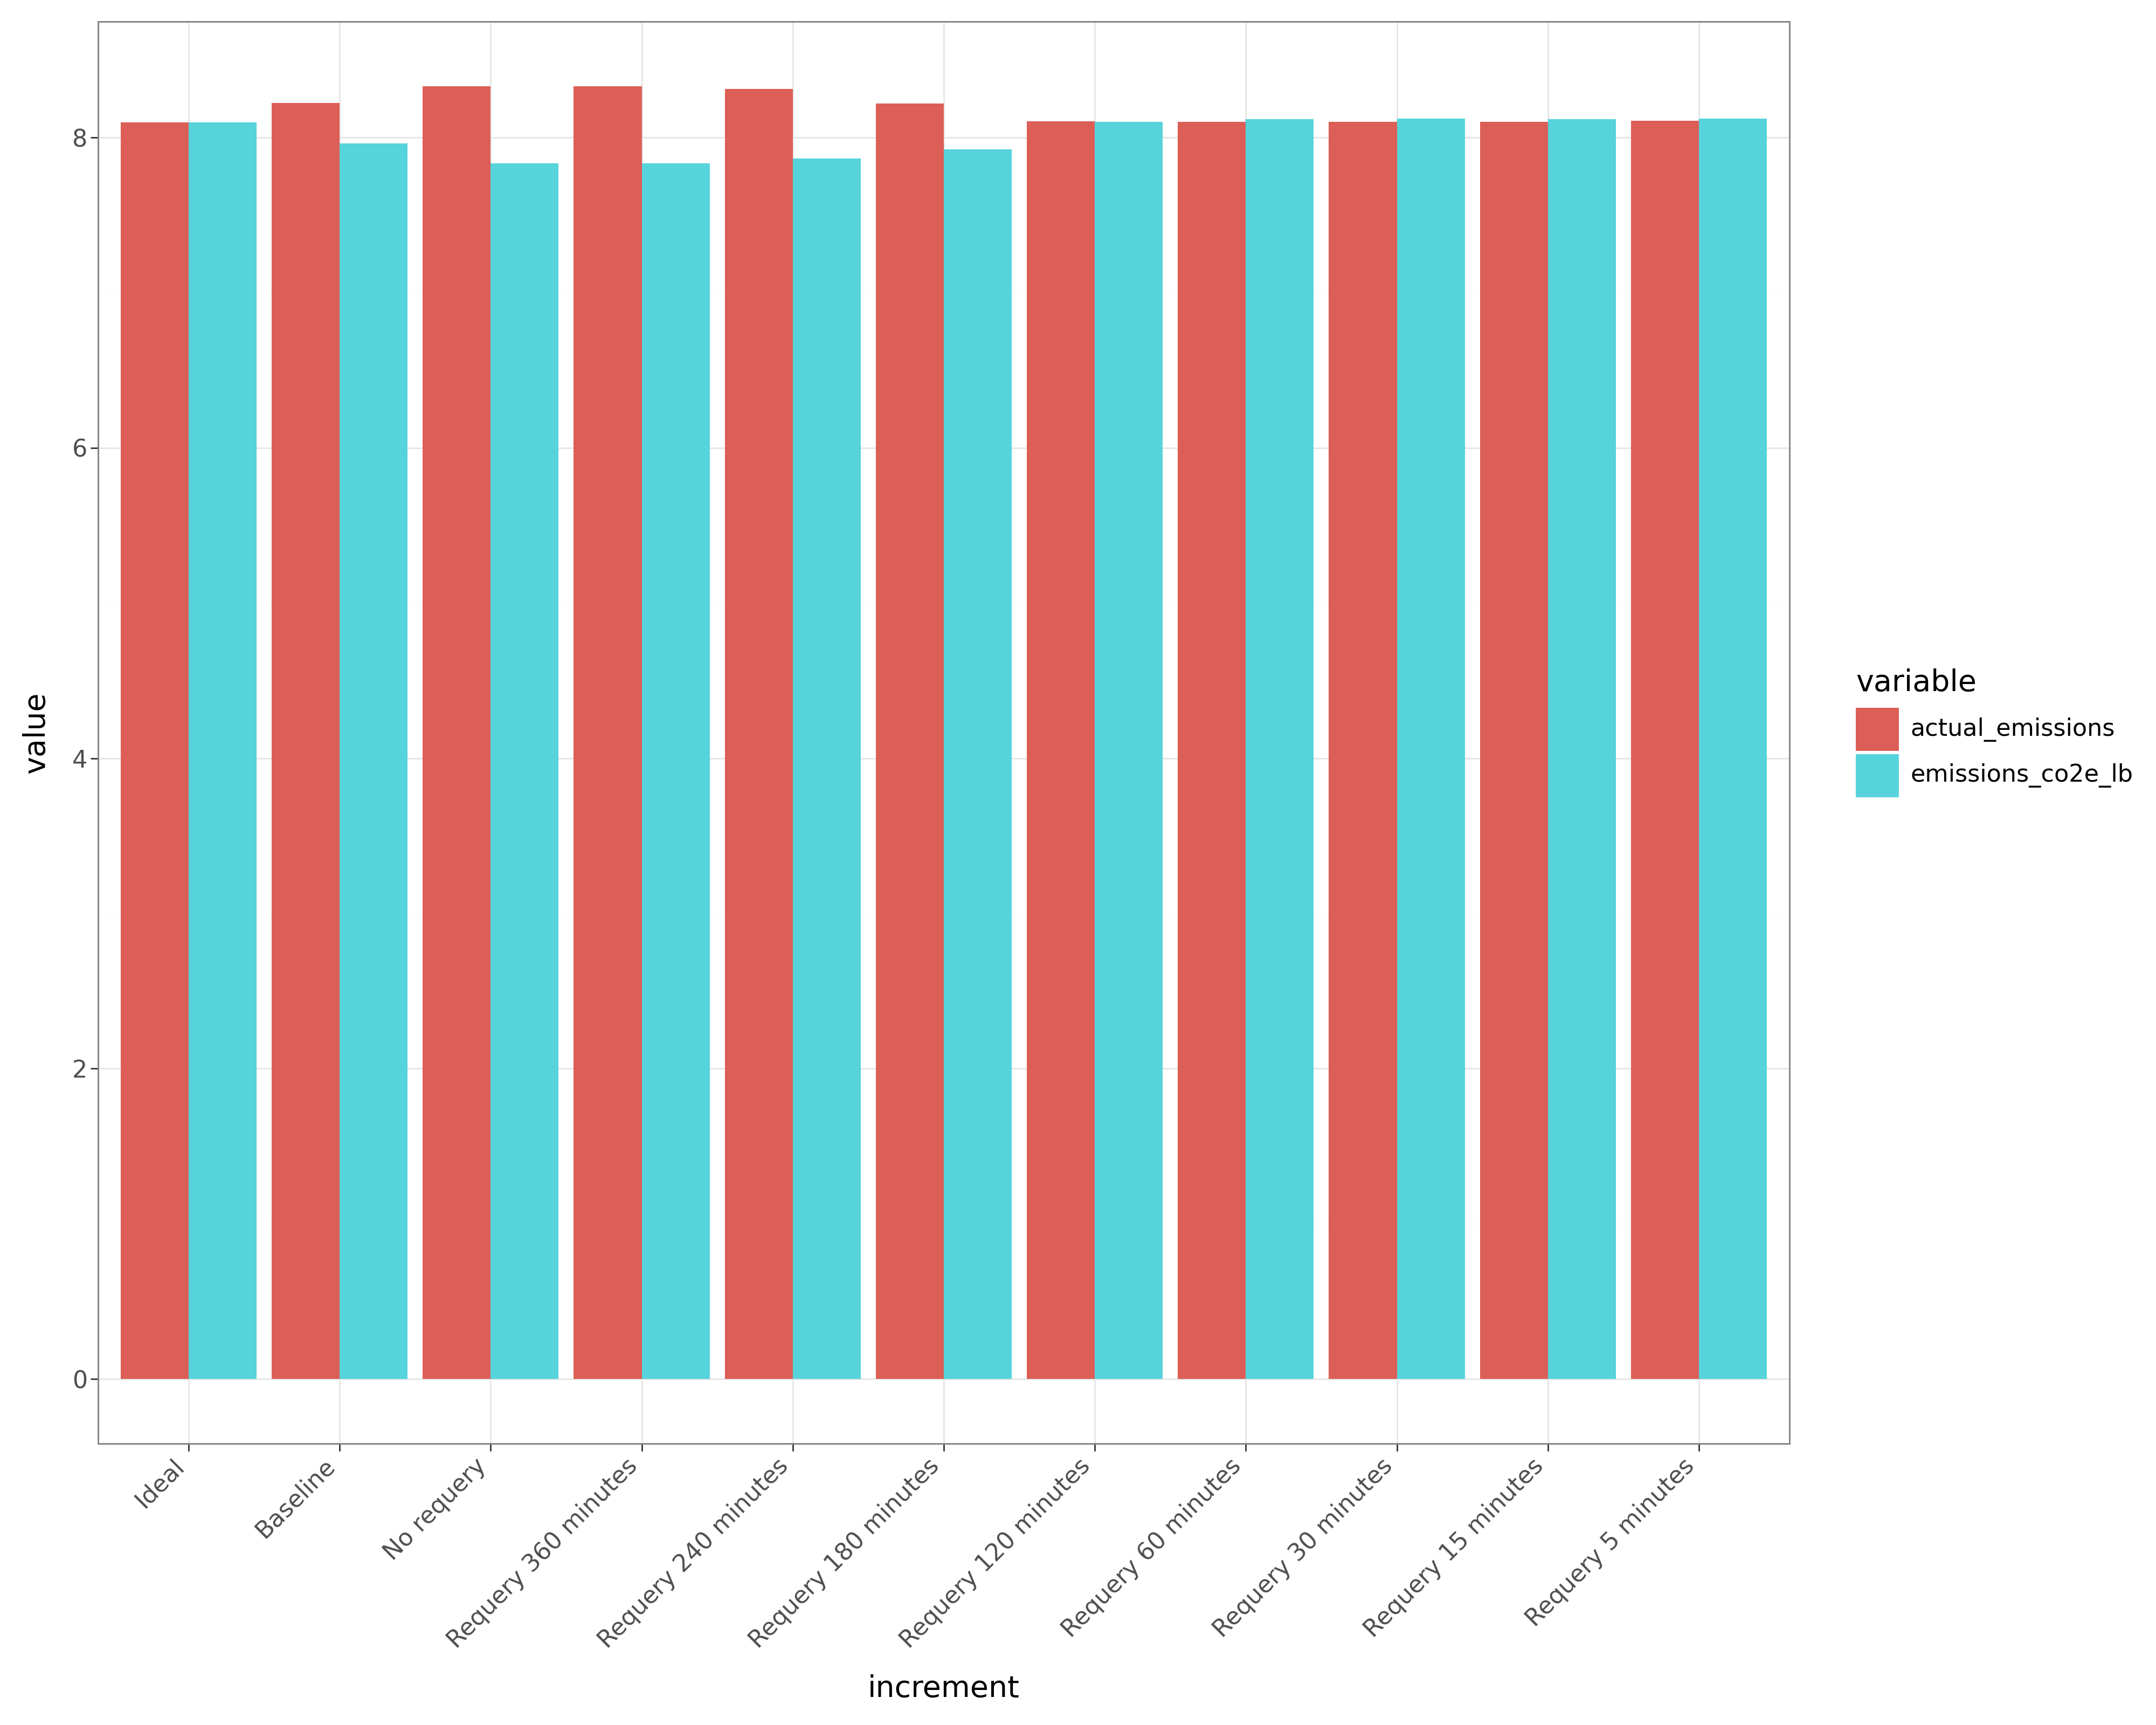